<a href="https://colab.research.google.com/github/adtitovich/dsml-17/blob/main/m5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задания:
В домашнем задании нужно улучшить метрики RMSE, R2 модели линейной регрессии путем работы с данными, а именно проведения разведочного анализа данных. В качестве датасета необходимо загрузить данные о недвижимости Калифорнии из библиотеки [sklearn.datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html). Целевая переменная – MedHouseVal. Прочитать информацию о признаках датасета можно, выполнив следующий код – print(fetch_california_housing().DESCR).

#Этапы работы:
**1. Получите данные и загрузите их в рабочую среду.**

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [170]:
housing = fetch_california_housing(as_frame=True)
data = pd.DataFrame(data= np.c_[housing['data'], housing['target']],
                     columns= housing['feature_names'] + ['MedHouseVal'])

**2. Проверьте данные на наличие пропусков. Удалите их в случае обнаружения.**

In [118]:
# пропусков нет
data.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

**3. Разделите выборку на обучающее и тестовое подмножества. 80% данных оставить на обучающее множество, 20% - на тестовое.**

In [171]:
X = data.drop(columns = ['MedHouseVal'])
y = data['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

**4. Постройте модель линейной регрессии. Вычислите метрики RMSE, R2 на обучающем и тестовом множестве.**

In [172]:
# строим модель
model = LinearRegression().fit(X_train, y_train)

In [173]:
# вычисляем метрики
pd.DataFrame({'Обучение':[mean_squared_error(y_train, model.predict(X_train), squared=False), 
                          r2_score(y_train, model.predict(X_train))], 
              'Тест':[mean_squared_error(y_test, model.predict(X_test), squared=False), 
                      r2_score(y_test, model.predict(X_test))]}, 
             index = ['RMSE', 'R2'])

,Обучение,Тест
RMSE,0.725864,0.725998
R2,0.604309,0.604162


**5. Постройте график распределения целевой переменной. Сделайте вывод. Присутствуют ли в этом признаке выбросы?**

<Axes: >

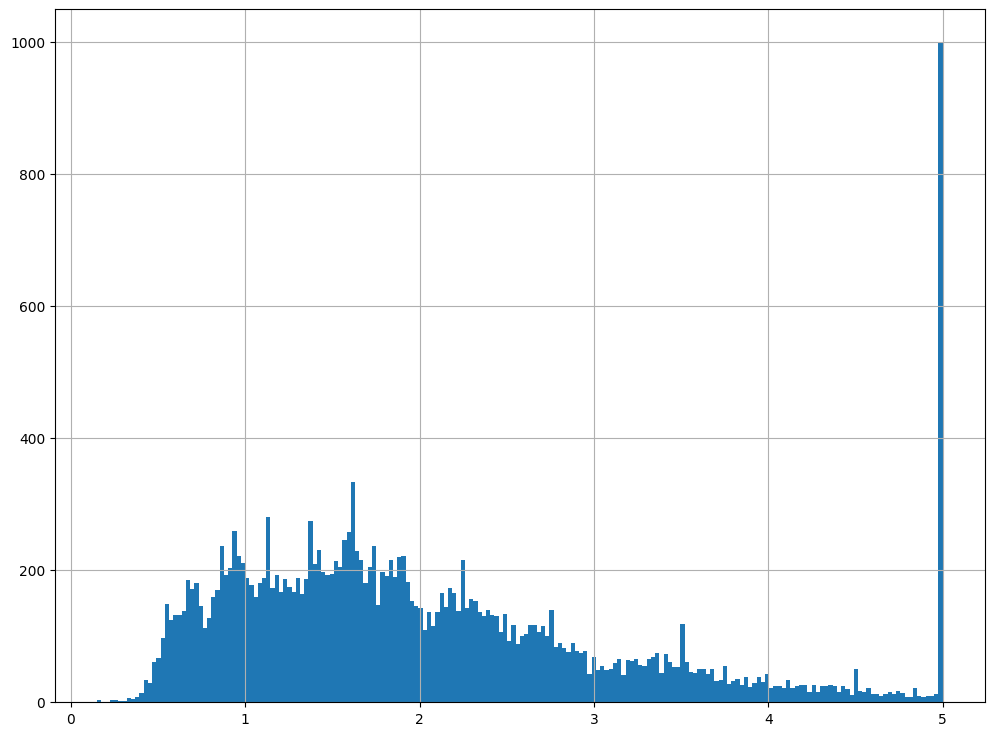

In [148]:
y.hist(bins=200, figsize=(12,9))

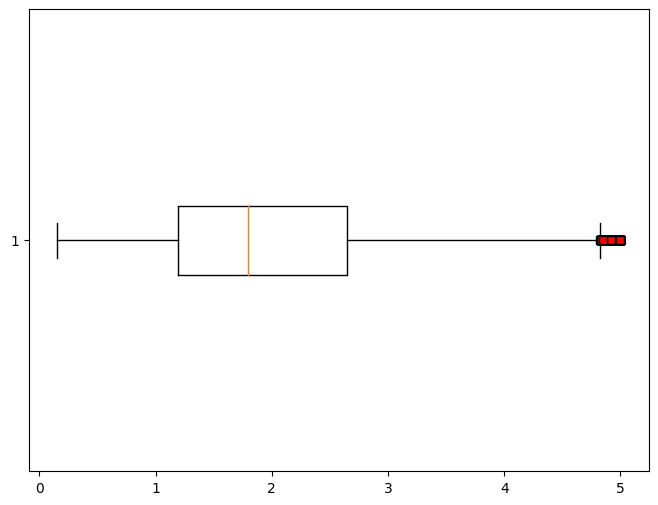

In [149]:
red_square = dict(markerfacecolor='r', marker='s') # выделим предполагаемые выбросы
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(y, vert=False, flierprops=red_square)
plt.show()

Можно предположить, что значении целевой переменной более 4.8 является выбросами. 

**6. Посчитайте и выведите корреляционную матрицу. Убедитесь, что ячейки матрицы поделены на цветные категории, в ячейках указано числовое значение корреляции.   
a. Сделайте выводы.   
b. Удалите признаки на основании полученных значений, выводов.   
c. Повторите п. 3, п. 4 на измененных данных.**

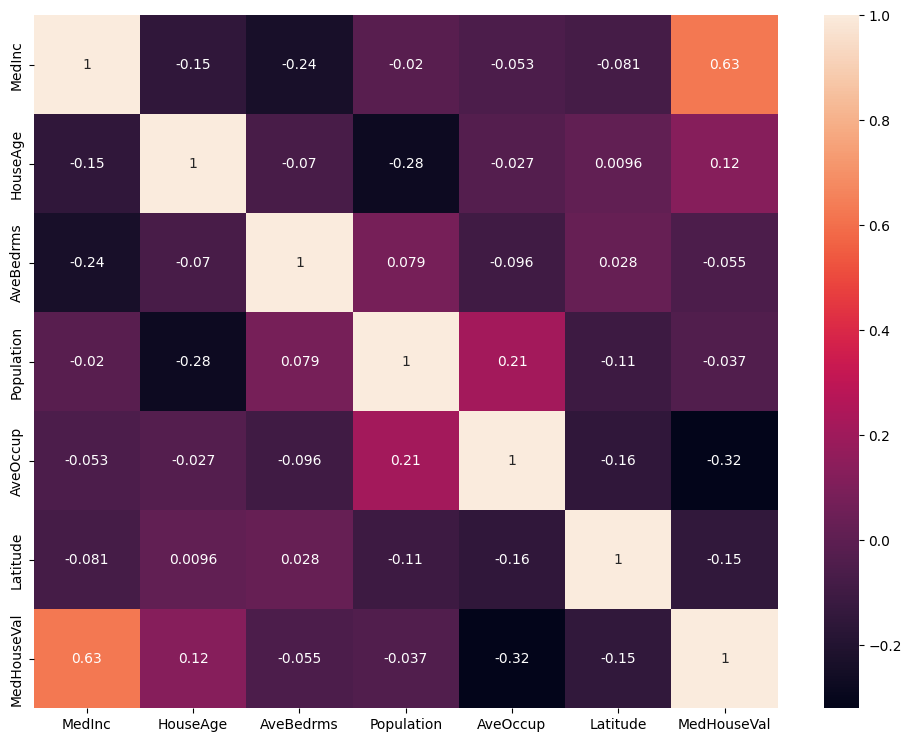

In [161]:
plt.figure(figsize=(12, 9))
sns.heatmap(data.corr(), annot = True)
plt.show()

У переменных AveRooms и	AveBedrms сильная положительная связь. У переменных Latitude и Longitude - сильная отрицательная связь.  
С целевой переменной сильная корреляция с MedInc

In [174]:
# удалим признаки AveRooms и Longitude
X = X.drop(columns=['AveRooms', 'Longitude'])

# делим выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

# строим модель
model = LinearRegression().fit(X_train, y_train)

# вычисляем метрики
pd.DataFrame({'Обучение':[mean_squared_error(y_train, model.predict(X_train), squared=False), 
                          r2_score(y_train, model.predict(X_train))], 
              'Тест':[mean_squared_error(y_test, model.predict(X_test), squared=False), 
                      r2_score(y_test, model.predict(X_test))]}, 
             index = ['RMSE', 'R2'])


,Обучение,Тест
RMSE,0.800221,0.816334
R2,0.519088,0.499525


**7. Исследуйте оставленные признаки на выбросы.  
a. Удалите выбросы в случае обнаружения.  
b. Повторите п. 3, п. 4 на измененных данных.**

In [195]:
#


from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV







search_model = IsolationForest(random_state=32)

param = {'n_estimators': [10, 300], 
              'max_samples': [10], 
              'contamination': ['auto'], 
              'max_features': [1, 6], 
              'bootstrap': [True], 
              'n_jobs': [-1]}

grid_search = GridSearchCV(search_model, 
                                           param,
                                           scoring="neg_mean_squared_error", 
                                           refit=True,
                                           cv=10, 
                                           return_train_score=True)
param_best = grid_search.fit(X_train, y_train).best_params_
print('Optimum parameters', param_best)


Optimum parameters {'bootstrap': True, 'contamination': 'auto', 'max_features': 6, 'max_samples': 10, 'n_estimators': 10, 'n_jobs': -1}


In [198]:
# Run the tuned Isolation Forest model

iforest = IsolationForest(random_state=16)
iforest.set_params(**param_best)


y_pred = iforest.fit_predict(X_train)

"""
iforest = IsolationForest(bootstrap=True,
                          contamination=0.0001, 
                          max_features=10, 
                          max_samples=10, 
                          n_estimators=1000, 
                          n_jobs=-1,
                         random_state=1)
y_pred = iforest.fit_predict(X_train)
"""

'\niforest = IsolationForest(bootstrap=True,\n                          contamination=0.0001, \n                          max_features=10, \n                          max_samples=10, \n                          n_estimators=1000, \n                          n_jobs=-1,\n                         random_state=1)\ny_pred = iforest.fit_predict(X_train)\n'

In [200]:
# Remove the outliers
X_train_iforest = X_train[(y_pred != -1), :]

#X_train_iforest, y_train_iforest = X_train[(y_pred != -1), :], y_train[(y_pred != -1)]

InvalidIndexError: ignored

удалим выбросы признаков, значения которых выходят за края статистически значимой выборки

In [175]:
data = data.drop(columns=['AveRooms', 'Longitude'])

In [176]:
k = 2
#MedInc
min_MedInc = data['MedInc'].quantile(0.25) - k*(data['MedInc'].quantile(0.75) - data['MedInc'].quantile(0.25))
max_MedInc = data['MedInc'].quantile(0.75) + k*(data['MedInc'].quantile(0.75) - data['MedInc'].quantile(0.25))

# AveRooms
min_AveRooms = data['AveBedrms'].quantile(0.25) - 1.5*(data['AveBedrms'].quantile(0.75) - data['AveBedrms'].quantile(0.25))
max_AveRooms = data['AveBedrms'].quantile(0.75) + 1.5*(data['AveBedrms'].quantile(0.75) - data['AveBedrms'].quantile(0.25))

# Population
min_Population = data['Population'].quantile(0.25) - 1.5*(data['Population'].quantile(0.75) - data['Population'].quantile(0.25))
max_Population = data['Population'].quantile(0.75) + 1.5*(data['Population'].quantile(0.75) - data['Population'].quantile(0.25))

# AveOccup
min_AveOccup = data['AveOccup'].quantile(0.25) - 1.5*(data['AveOccup'].quantile(0.75) - data['AveOccup'].quantile(0.25))
max_AveOccup = data['AveOccup'].quantile(0.75) + 1.5*(data['AveOccup'].quantile(0.75) - data['AveOccup'].quantile(0.25))



In [177]:
data = data.drop(data[~data['MedInc'].between(min_MedInc, max_MedInc)].index)
data = data.drop(data[~data['AveBedrms'].between(min_AveRooms, max_AveRooms)].index)
data = data.drop(data[~data['Population'].between(min_Population, max_Population)].index)
data = data.drop(data[~data['AveOccup'].between(min_AveOccup, max_AveOccup)].index)


In [178]:
X = data.drop(columns = ['MedHouseVal'])
y = data['MedHouseVal']

# делим выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# строим модель
model = LinearRegression().fit(X_train, y_train)

# вычисляем метрики
pd.DataFrame({'Обучение':[mean_squared_error(y_train, model.predict(X_train), squared=False), 
                          r2_score(y_train, model.predict(X_train))], 
              'Тест':[mean_squared_error(y_test, model.predict(X_test), squared=False), 
                      r2_score(y_test, model.predict(X_test))]}, 
             index = ['RMSE', 'R2'])

,Обучение,Тест
RMSE,0.717057,0.704787
R2,0.548375,0.590006


In [86]:

# Предположим, что MedInc>8 - выбросы
X = X.drop(X[X['MedInc'] > X2].index)

In [77]:
X.quantile(0.5)

MedInc           3.467750
HouseAge        29.000000
AveRooms         5.176783
Population    1171.000000
AveOccup         2.816946
Latitude        34.260000
Name: 0.5, dtype: float64

In [88]:
X1 = X['MedInc'].quantile(0.25) - 1.5*(X['MedInc'].quantile(0.75) - X['MedInc'].quantile(0.25))
X2 = X['MedInc'].quantile(0.75) + 1.5*(X['MedInc'].quantile(0.75) - X['MedInc'].quantile(0.25))
print(X1)
print(X2)

-0.5123999999999995
7.5916


In [160]:
X.describe()

,MedInc,HouseAge,AveBedrms,Population,AveOccup,Latitude
count,16959.000000,16959.000000,16959.000000,16959.000000,16959.000000,16959.000000
mean,3.713877,29.643965,1.048046,1268.666431,2.846289,35.651755
std,1.488739,12.279887,0.066744,632.960938,0.632416,2.130948
min,0.536000,1.000000,0.866667,5.000000,1.161290,32.540000
25%,2.579600,19.000000,1.003317,808.500000,2.415960,33.940000
50%,3.532600,30.000000,1.044503,1155.000000,2.798450,34.270000
75%,4.659100,38.000000,1.089558,1630.500000,3.232143,37.730000
max,8.011300,52.000000,1.240506,3183.000000,4.572864,41.950000


Измените несколько признаков на выбор математически. Например, вычислите логарифм, возведите в квадрат, извлеките квадратный корень.
a. Повторите п. 3, п. 4 на измененных данных.

Сформулируйте выводы по проделанной работе.
a. Кратко опишите какие преобразования были сделаны с данными.
b. Сравните метрики всех моделей. Желательно оформление в виде таблицы вида |модель|RMSE|R2|признаки, на которых проводилось обучение с указанием их преобразований|.
c. Напишите свое мнение, в полной ли мере модели справились с поставленной задачей.
Для получения зачета по этому домашнему заданию, минимально, должно быть реализовано обучение трех моделей классификации: на основе всех неизмененных признаков; на основе признаков, отобранных по значениям корреляций; на основе признаков, отобранных по значениям корреляций и с удалением выбросов в них. Должны быть выведены метрики RMSE, R2 моделей. Желательно добиться улучшения метрик.